In [1]:
# from qiskit import *
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi

from qiskit_ionq import IonQProvider
# import gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
from qiskit import Aer, execute, assemble

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# To supress the deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
#%run utility_functions.ipynb

provider = IonQProvider("RmK0yNkCDPmoxCH12uQ4U67lpu9kFgik")
native_simulator = provider.get_backend("ionq_simulator", gateset="native")

In [2]:
def fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval):
    
    if bitval == 1:
        B = (out001 + out011 + out101 + out111)/1024
        E = (out010 + out011 + out110 + out111)/1024
        A = (out100 + out101 + out110 + out111)/1024
        
    if bitval == 0:
        B = (out010 + out000 + out110 + out100)/1024
        E = (out001 + out000 + out101 + out100)/1024
        A = (out000 + out001 + out010 + out011)/1024
        
    return B,E,A 

In [3]:
def alice_prepares(qc, bitval, basis):
    if basis == 'X' and bitval == 1: # initial state is |->
        #qc.x(0)
        #qc.h(0)
        qc.append(GPIGate(0), [0])
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(0), [0])
        return qc
    if basis == 'X' and bitval == 0: # initial state is |+>
        #qc.h(0)
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(0), [0])
        return qc
    if basis == 'Y' and bitval == 1: # initial state |-i>
        #qc.rx(np.pi/2, 0)
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(-1/8), [0])
        return qc
    if basis == 'Y' and bitval == 0: # initial state |+i>
        #qc.rx(-np.pi/2, 0)
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(1/8), [0])
        return qc

In [4]:
def measurement_prep(qc, bitval, basis):
    
    if basis == 'X':
        #qc.h(0)
        qc.append(GPI2Gate(1/4), [0])
        qc.append(GPIGate(0), [0])
        #qc.h(1)
        qc.append(GPI2Gate(1/4), [1])
        qc.append(GPIGate(0), [1])
        #qc.h(2)
        qc.append(GPI2Gate(1/4), [2])
        qc.append(GPIGate(0), [2])
    
    if basis == 'Y':
        #qc.rx(np.pi/2, 0)
   #     qc.append(GPI2Gate(0), [0])
        qc.append(GPIGate(1/8), [0])
        qc.append(GPI2Gate(-.25), [0])
        #qc.rx(np.pi/2, 1)
   #     qc.append(GPI2Gate(0), [1])
        qc.append(GPIGate(1/8), [1])
        qc.append(GPI2Gate(-.25), [1])
        #qc.rx(np.pi/2, 2)
   #     qc.append(GPI2Gate(0), [2])
        qc.append(GPIGate(1/8), [2])
        qc.append(GPI2Gate(-.25), [2])
    
    return qc

In [5]:
def eve_clones(qc, theta2):
    theta = [np.pi/4, theta2, theta2]
        
    #Eve Prep
        
#    qc.append(GPIGate(1/8), [1])
#    qc.append(GPIGate(0), [1])
#    qc.append(GPI2Gate(1/4), [1])
#    qc.append(GPIGate((theta[0] + np.pi/4)/(2 * np.pi)), [1])
#    qc.append(GPI2Gate(1/4), [1])
#    qc.append(GPIGate(1/8), [1])

    qc.append(GPIGate(1/4), [1])
    
    qc.append(MSGate(0,0), [1,2])
    
    qc.append(GPIGate(1/8), [1])
    
    qc.append(GPIGate((np.pi/4 - theta[1])/(2 * np.pi)), [2])
    
    qc.append(MSGate(0,0), [2,1])
    
    qc.append(GPI2Gate(-1/4),[2])
     
    
    qc.append(GPIGate(1/8),[1])
    qc.append(GPIGate(0), [1])
    qc.append(GPI2Gate(1/4), [1])
    qc.append(GPIGate(theta[2]/(2*np.pi)), [1])
    qc.append(GPI2Gate(1/4), [1])
    qc.append(GPIGate(1/8), [1])
    
    #Eve Clone
    
    qc.append(GPI2Gate(1/4), [0])
    
    qc.append(MSGate(0,0), [0,1])
    
    qc.append(MSGate(0,0), [0,2])
    
    qc.append(GPI2Gate(1/4), [0])
    
    qc.append(GPIGate(1/8), [2])
    
    qc.append(GPIGate(1/8), [1])
    
    qc.append(MSGate(0,0), [1,0])
    
    qc.append(GPI2Gate(-1/4), [1])
    
    qc.append(MSGate(0,0), [2,0])
    
    qc.append(GPI2Gate(-1/4), [2])

    
    return qc

In [6]:
def run_experiment(theta2, bitval, basis):
    qc = QuantumCircuit(3,3)
    
    # Alice prepares her qubit to send
    alice_prepares(qc, bitval, basis)
    qc.barrier()
    
    # Eve clones the flying qubit
    eve_clones(qc, theta2)
    
    qc.barrier()
    # Bob and Eve prepare to measure
    measurement_prep(qc, bitval, basis)
    
    qc.barrier()
    
    # Bob and Eve measure
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)
    
    shots = 1024 # number of samples used for statistics
    job = native_simulator.run(qc)
    probs = job.get_probabilities()
    
    out000 = job.result().get_counts().get("000")
    out001 = job.result().get_counts().get("001")
    out010 = job.result().get_counts().get("010")
    out011 = job.result().get_counts().get("011")
    out100 = job.result().get_counts().get("100")
    out101 = job.result().get_counts().get("101")
    out110 = job.result().get_counts().get("110")
    out111 = job.result().get_counts().get("111")

    if out000 == None:
        out000 = 0
    if out001 == None:
        out001 = 0
    if out010 == None:
        out010 = 0
    if out011 == None:
        out011 = 0
        
    if out100 == None:
        out100 = 0
    if out101 == None:
        out101 = 0
    if out110 == None:
        out110 = 0
    if out111 == None:
        out111 = 0
        
    #print(f"out000 = {out000}; out001 = {out001}; out010 = {out010}; out011={out011}")
    #print(f"out100 = {out100}; out101 = {out101}; out110 = {out110}; out111={out111}")
    
    b, e, a = fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval)
    
    
    #print(f"Bob = {b}: Eve = {e}: Ancilla = {a}")
    return qc, b, e, a

In [7]:
qc, B, E, A = run_experiment(np.pi/8 + 0.079, 0, 'X')
print(B,E,A)
qc.draw()

0.91796875 0.7998046875 0.7529296875


┌────────────┐┌────────┐ ░ ┌────────────┐                 »
q_0: ┤ Gpi2(0.25) ├┤ Gpi(0) ├─░─┤ Gpi2(0.25) ├─────────────────»
     └────────────┘└────────┘ ░ ├───────────┬┘┌───────────────┐»
q_1: ─────────────────────────░─┤ Gpi(0.25) ├─┤0              ├»
                              ░ └───────────┘ │  Ms(0,0,0.25) │»
q_2: ─────────────────────────░───────────────┤1              ├»
                              ░               └───────────────┘»
c_0: ══════════════════════════════════════════════════════════»
                                                               »
c_1: ══════════════════════════════════════════════════════════»
                                                               »
c_2: ══════════════════════════════════════════════════════════»
                                                               »
«                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────»
«       ┌────────────┐ ┌───────────────┐ ┌────────────┐┌────────┐┌────────────┐»
«q_1: ──┤ Gpi(0.125) ├─┤1              ├─┤ Gpi(0.125) ├┤ Gpi(0) ├┤ Gpi2(0.25) ├»
«     ┌─┴────────────┴┐│  Ms(0,0,0.25) │┌┴────────────┤└────────┘└────────────┘»
«q_2: ┤ Gpi(0.049927) ├┤0              ├┤ Gpi2(-0.25) ├────────────────────────»
«     └───────────────┘└───────────────┘└─────────────┘                        »
«c_0: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_1: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_2: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                  ┌───────────────┐»
«q_0: ─────────────────────────────────────────────┤0              ├»
«     ┌───────────────┐┌────────────┐┌────────────┐│  Ms(0,0,0.25) │»
«q_1: ┤ Gpi(0.075073) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├┤1              ├»
«     └───────────────┘└────────────┘└────────────┘└───────────────┘»
«q_2: ──────────────────────────────────────────────────────────────»
«                                                                   »
«c_0: ══════════════════════════════════════════════════════════════»
«                                                                   »
«c_1: ══════════════════════════════════════════════════════════════»
«                                                                   »
«c_2: ══════════════════════════════════════════════════════════════»
«                                                                   »
«     ┌───────────────┐┌────────────┐┌───────────────┐               »
«q_0: ┤0              ├┤ Gpi2(0.25) ├┤1              ├───────────────»
«     │               │├────────────┤│  Ms(0,0,0.25) │┌─────────────┐»
«q_1: ┤  Ms(0,0,0.25) ├┤ Gpi(0.125) ├┤0              ├┤ Gpi2(-0.25) ├»
«     │               │├────────────┤└───────────────┘└─────────────┘»
«q_2: ┤1              ├┤ Gpi(0.125) ├────────────────────────────────»
«     └───────────────┘└────────────┘                                »
«c_0: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«c_1: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«c_2: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«     ┌───────────────┐                ░ ┌────────────┐┌────────┐ ░ ┌─┐      
«q_0: ┤1              ├────────────────░─┤ Gpi2(0.25) ├┤ Gpi(0) ├─░─┤M├──────
«     │               │                ░ ├────────────┤├────────┤ ░ └╥┘┌─┐   
«q_1: ┤  Ms(0,0,0.25) ├────────────────░

In [8]:
qc, B, E, A = run_experiment(np.pi/8 + 0.079, 1, 'X')
print(B,E,A)
qc.draw()

0.8984375 0.7734375 0.716796875


┌────────┐┌────────────┐┌────────┐ ░ ┌────────────┐                 »
q_0: ┤ Gpi(0) ├┤ Gpi2(0.25) ├┤ Gpi(0) ├─░─┤ Gpi2(0.25) ├─────────────────»
     └────────┘└────────────┘└────────┘ ░ ├───────────┬┘┌───────────────┐»
q_1: ───────────────────────────────────░─┤ Gpi(0.25) ├─┤0              ├»
                                        ░ └───────────┘ │  Ms(0,0,0.25) │»
q_2: ───────────────────────────────────░───────────────┤1              ├»
                                        ░               └───────────────┘»
c_0: ════════════════════════════════════════════════════════════════════»
                                                                         »
c_1: ════════════════════════════════════════════════════════════════════»
                                                                         »
c_2: ════════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────»
«       ┌────────────┐ ┌───────────────┐ ┌────────────┐┌────────┐┌────────────┐»
«q_1: ──┤ Gpi(0.125) ├─┤1              ├─┤ Gpi(0.125) ├┤ Gpi(0) ├┤ Gpi2(0.25) ├»
«     ┌─┴────────────┴┐│  Ms(0,0,0.25) │┌┴────────────┤└────────┘└────────────┘»
«q_2: ┤ Gpi(0.049927) ├┤0              ├┤ Gpi2(-0.25) ├────────────────────────»
«     └───────────────┘└───────────────┘└─────────────┘                        »
«c_0: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_1: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_2: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                  ┌───────────────┐»
«q_0: ─────────────────────────────────────────────┤0              ├»
«     ┌───────────────┐┌────────────┐┌────────────┐│  Ms(0,0,0.25) │»
«q_1: ┤ Gpi(0.075073) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├┤1              ├»
«     └───────────────┘└────────────┘└────────────┘└───────────────┘»
«q_2: ──────────────────────────────────────────────────────────────»
«                                                                   »
«c_0: ══════════════════════════════════════════════════════════════»
«                                                                   »
«c_1: ══════════════════════════════════════════════════════════════»
«                                                                   »
«c_2: ══════════════════════════════════════════════════════════════»
«                                                                   »
«     ┌───────────────┐┌────────────┐┌───────────────┐               »
«q_0: ┤0              ├┤ Gpi2(0.25) ├┤1              ├───────────────»
«     │               │├────────────┤│  Ms(0,0,0.25) │┌─────────────┐»
«q_1: ┤  Ms(0,0,0.25) ├┤ Gpi(0.125) ├┤0              ├┤ Gpi2(-0.25) ├»
«     │               │├────────────┤└───────────────┘└─────────────┘»
«q_2: ┤1              ├┤ Gpi(0.125) ├────────────────────────────────»
«     └───────────────┘└────────────┘                                »
«c_0: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«c_1: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«c_2: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«     ┌───────────────┐                ░ ┌────────────┐┌────────┐ ░ ┌─┐      
«q_0: ┤1              ├────────────────░─┤ Gpi2(0.25) ├┤ Gpi(0) ├─

In [9]:
qc, B, E, A = run_experiment(np.pi/8 + 0.079, 0, 'Y')
print(B,E,A)
qc.draw()

0.1103515625 0.794921875 0.7392578125


┌────────────┐┌────────────┐ ░ ┌────────────┐                 »
q_0: ┤ Gpi2(0.25) ├┤ Gpi(0.125) ├─░─┤ Gpi2(0.25) ├─────────────────»
     └────────────┘└────────────┘ ░ ├───────────┬┘┌───────────────┐»
q_1: ─────────────────────────────░─┤ Gpi(0.25) ├─┤0              ├»
                                  ░ └───────────┘ │  Ms(0,0,0.25) │»
q_2: ─────────────────────────────░───────────────┤1              ├»
                                  ░               └───────────────┘»
c_0: ══════════════════════════════════════════════════════════════»
                                                                   »
c_1: ══════════════════════════════════════════════════════════════»
                                                                   »
c_2: ══════════════════════════════════════════════════════════════»
                                                                   »
«                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────»
«       ┌────────────┐ ┌───────────────┐ ┌────────────┐┌────────┐┌────────────┐»
«q_1: ──┤ Gpi(0.125) ├─┤1              ├─┤ Gpi(0.125) ├┤ Gpi(0) ├┤ Gpi2(0.25) ├»
«     ┌─┴────────────┴┐│  Ms(0,0,0.25) │┌┴────────────┤└────────┘└────────────┘»
«q_2: ┤ Gpi(0.049927) ├┤0              ├┤ Gpi2(-0.25) ├────────────────────────»
«     └───────────────┘└───────────────┘└─────────────┘                        »
«c_0: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_1: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_2: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                  ┌───────────────┐»
«q_0: ─────────────────────────────────────────────┤0              ├»
«     ┌───────────────┐┌────────────┐┌────────────┐│  Ms(0,0,0.25) │»
«q_1: ┤ Gpi(0.075073) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├┤1              ├»
«     └───────────────┘└────────────┘└────────────┘└───────────────┘»
«q_2: ──────────────────────────────────────────────────────────────»
«                                                                   »
«c_0: ══════════════════════════════════════════════════════════════»
«                                                                   »
«c_1: ══════════════════════════════════════════════════════════════»
«                                                                   »
«c_2: ══════════════════════════════════════════════════════════════»
«                                                                   »
«     ┌───────────────┐┌────────────┐┌───────────────┐               »
«q_0: ┤0              ├┤ Gpi2(0.25) ├┤1              ├───────────────»
«     │               │├────────────┤│  Ms(0,0,0.25) │┌─────────────┐»
«q_1: ┤  Ms(0,0,0.25) ├┤ Gpi(0.125) ├┤0              ├┤ Gpi2(-0.25) ├»
«     │               │├────────────┤└───────────────┘└─────────────┘»
«q_2: ┤1              ├┤ Gpi(0.125) ├────────────────────────────────»
«     └───────────────┘└────────────┘                                »
«c_0: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«c_1: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«c_2: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«     ┌───────────────┐                ░ ┌────────────┐┌─────────────┐ ░ ┌─┐   »
«q_0: ┤1              ├────────────────░─┤ Gpi(0.125) ├┤ Gpi2(-0.25) ├─░─┤M├───»
«     │               │                ░ ├────────────┤├────

In [10]:
qc, B, E, A = run_experiment(np.pi/8 + 0.079, 1, 'Y')
print(B,E,A)
qc.draw()

0.1005859375 0.7900390625 0.73046875


┌────────────┐┌─────────────┐ ░ ┌────────────┐                 »
q_0: ┤ Gpi2(0.25) ├┤ Gpi(-0.125) ├─░─┤ Gpi2(0.25) ├─────────────────»
     └────────────┘└─────────────┘ ░ ├───────────┬┘┌───────────────┐»
q_1: ──────────────────────────────░─┤ Gpi(0.25) ├─┤0              ├»
                                   ░ └───────────┘ │  Ms(0,0,0.25) │»
q_2: ──────────────────────────────░───────────────┤1              ├»
                                   ░               └───────────────┘»
c_0: ═══════════════════════════════════════════════════════════════»
                                                                    »
c_1: ═══════════════════════════════════════════════════════════════»
                                                                    »
c_2: ═══════════════════════════════════════════════════════════════»
                                                                    »
«                                                                              »
«q_0: ─────────────────────────────────────────────────────────────────────────»
«       ┌────────────┐ ┌───────────────┐ ┌────────────┐┌────────┐┌────────────┐»
«q_1: ──┤ Gpi(0.125) ├─┤1              ├─┤ Gpi(0.125) ├┤ Gpi(0) ├┤ Gpi2(0.25) ├»
«     ┌─┴────────────┴┐│  Ms(0,0,0.25) │┌┴────────────┤└────────┘└────────────┘»
«q_2: ┤ Gpi(0.049927) ├┤0              ├┤ Gpi2(-0.25) ├────────────────────────»
«     └───────────────┘└───────────────┘└─────────────┘                        »
«c_0: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_1: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«c_2: ═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                  ┌───────────────┐»
«q_0: ─────────────────────────────────────────────┤0              ├»
«     ┌───────────────┐┌────────────┐┌────────────┐│  Ms(0,0,0.25) │»
«q_1: ┤ Gpi(0.075073) ├┤ Gpi2(0.25) ├┤ Gpi(0.125) ├┤1              ├»
«     └───────────────┘└────────────┘└────────────┘└───────────────┘»
«q_2: ──────────────────────────────────────────────────────────────»
«                                                                   »
«c_0: ══════════════════════════════════════════════════════════════»
«                                                                   »
«c_1: ══════════════════════════════════════════════════════════════»
«                                                                   »
«c_2: ══════════════════════════════════════════════════════════════»
«                                                                   »
«     ┌───────────────┐┌────────────┐┌───────────────┐               »
«q_0: ┤0              ├┤ Gpi2(0.25) ├┤1              ├───────────────»
«     │               │├────────────┤│  Ms(0,0,0.25) │┌─────────────┐»
«q_1: ┤  Ms(0,0,0.25) ├┤ Gpi(0.125) ├┤0              ├┤ Gpi2(-0.25) ├»
«     │               │├────────────┤└───────────────┘└─────────────┘»
«q_2: ┤1              ├┤ Gpi(0.125) ├────────────────────────────────»
«     └───────────────┘└────────────┘                                »
«c_0: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«c_1: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«c_2: ═══════════════════════════════════════════════════════════════»
«                                                                    »
«     ┌───────────────┐                ░ ┌────────────┐┌─────────────┐ ░ ┌─┐   »
«q_0: ┤1              ├────────────────░─┤ Gpi(0.125) ├┤ Gpi2(-0.25) ├─░─┤M├───»
«     │               │                ░ ├─────

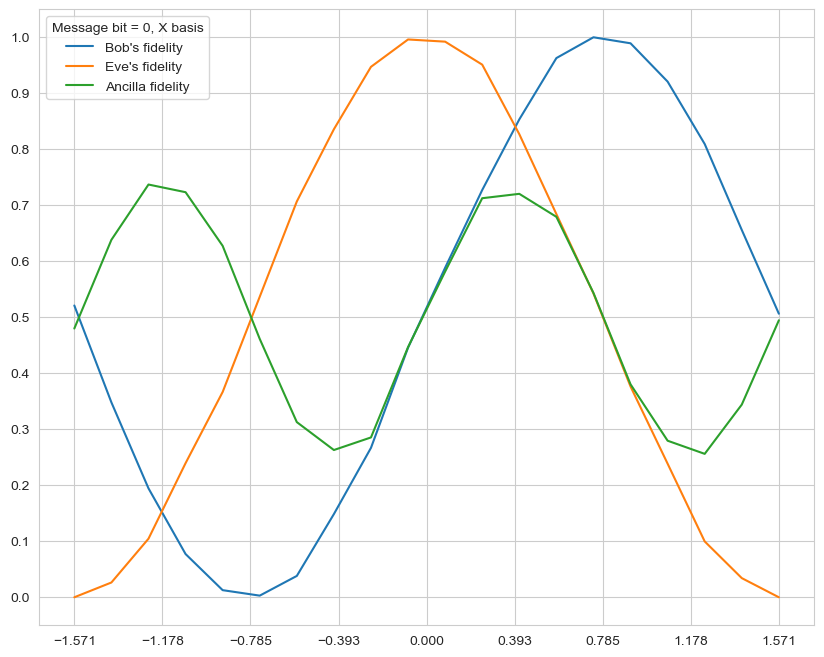

In [11]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
B = []
E = []
A = []
for j in range(len(ts)):
    qc, b, e, a = run_experiment(ts[j],0, 'X')
    B.append(b)
    E.append(e)
    A.append(a)

B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(ts, B, label = "Bob's fidelity")
plt.plot(ts, E, label = "Eve's fidelity")
plt.plot(ts, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 0, X basis")
plt.show()

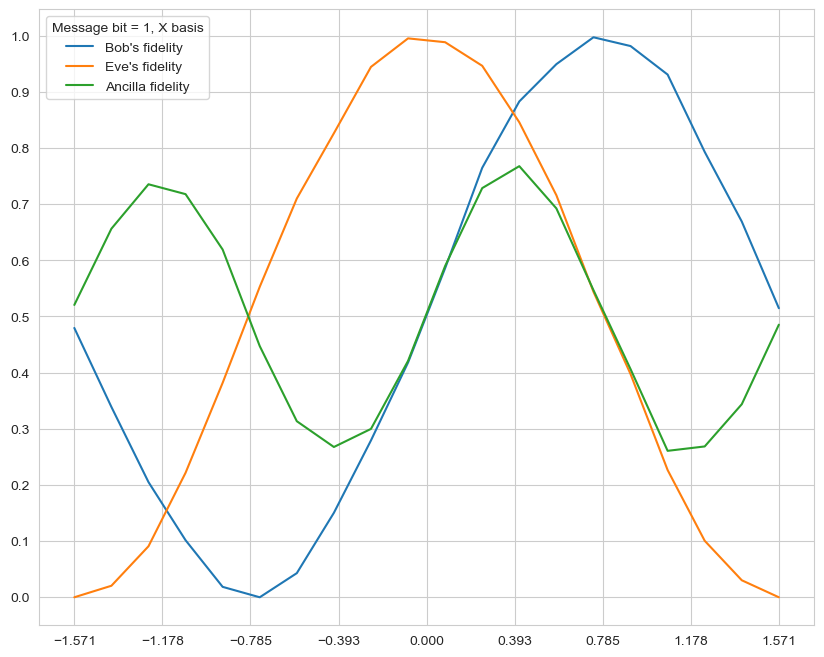

In [12]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
B = []
E = []
A = []
for j in range(len(ts)):
    qc, b, e, a = run_experiment(ts[j],1, 'X')
    B.append(b)
    E.append(e)
    A.append(a)

B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(ts, B, label = "Bob's fidelity")
plt.plot(ts, E, label = "Eve's fidelity")
plt.plot(ts, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 1, X basis")
plt.show()

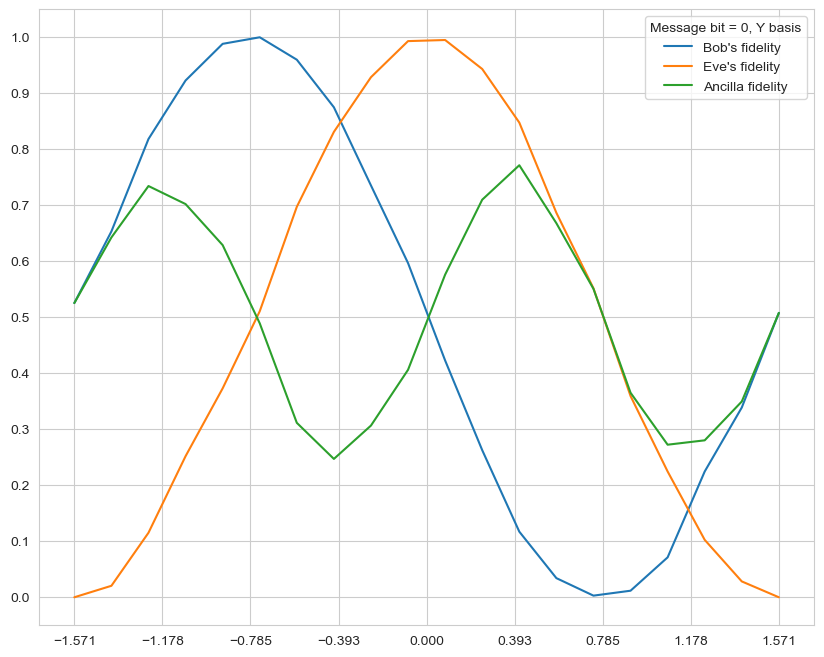

In [13]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
B = []
E = []
A = []
for j in range(len(ts)):
    qc, b, e, a = run_experiment(ts[j],0, 'Y')
    B.append(b)
    E.append(e)
    A.append(a)

B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(ts, B, label = "Bob's fidelity")
plt.plot(ts, E, label = "Eve's fidelity")
plt.plot(ts, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 0, Y basis")
plt.show()

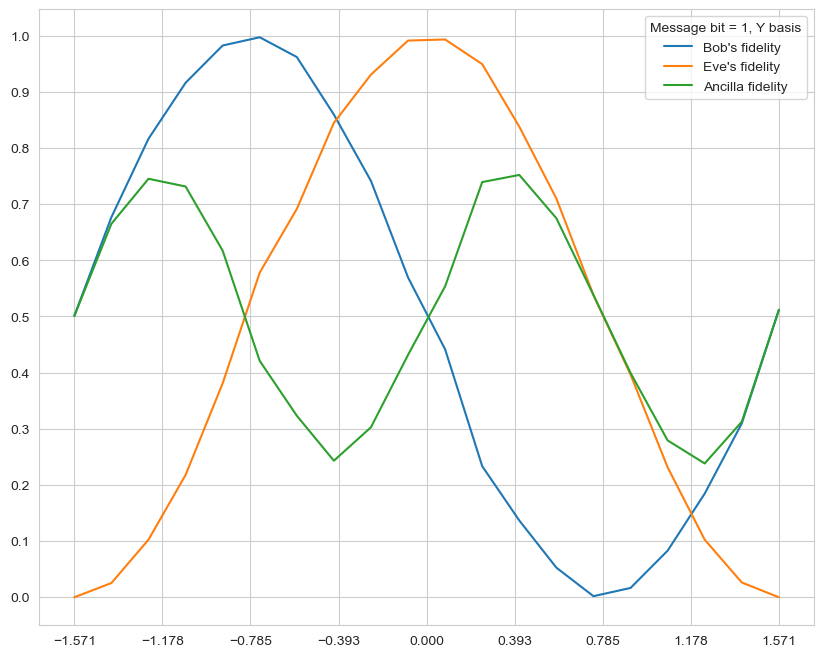

In [14]:
ts = np.linspace(-np.pi/2, np.pi/2, 20)
B = []
E = []
A = []
for j in range(len(ts)):
    qc, b, e, a = run_experiment(ts[j],1, 'Y')
    B.append(b)
    E.append(e)
    A.append(a)

B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(ts, B, label = "Bob's fidelity")
plt.plot(ts, E, label = "Eve's fidelity")
plt.plot(ts, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(-np.pi/2, 5*np.pi/8, step = np.pi/8))
plt.legend(title="Message bit = 1, Y basis")
plt.show()